In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### ドリフトの決定(u_t:=0.5t)

In [2]:
def drift(t):#ドリフトの決定
    return 0.5*t #ここではu_t=0.5tとした

### Cameron-Martin空間の基底の微分(詳細は[1][4]参照)

In [3]:
def h_dot(n,t):
    incos=(n-0.5)*np.pi*t/T
    return np.power(2/T,0.5)*np.cos(incos)/sigma

### 作用素に対する各基底の固有値

In [4]:
def lamda(n):
    return sigma*T/(np.pi*(n-0.5))

### 独自の工夫ポイント
### カメロンマルティン空間の基底の微分を定義関数で近似したうえで微分とWiener汎関数の線形性に頼る

In [5]:
def X_h(k):#独自の工夫ポイント。カメロンマルティンの基底の微分を定義関数で近似したうえで微分とXの線形性に頼る
    sum=0
    for i in range(m):
        t=i*T/m
        sum += h_dot(k,t+delta_t)*(X[i+1]-X[i])
    return sum

### 大枠のセッティング

In [6]:
T = 1.0  #終端時刻
sigma = 1.0 #σの値
m = 1000 #時間の分割数
t = 0 #初期時刻
X = [0]*(m+1)  #確率微分方程式のサンプルパスを格納
uhat = [0]*(m+1) #推定量を格納
loss_X = [0]*(m) #最尤推定の平均二乗誤差の記録用配列
loss_XDF = [0]*(m) #シュタイン推定の平均二乗誤差の記録用配列
delta_t = T/m  #Δt
sigma_t = np.power(delta_t,0.5)#ブラウン運動実装のための標準偏差計算
monte_count=100000 #モンテカルロ法を回す回数

### モンテカルロ法を回す

In [7]:
for l in range(monte_count):
    n=5 #近似の次元は5とした（カメロンマルティン空間は無限次元なので、どんなに増やしても完璧ではない）
    X_h_array=[0]*(n) #X_h(k)を記録しておくことで計算を高速化する
    denominator=0 #シュタイン推定の補正項の分母。詳細は[1]を参照
    delta_W = np.random.normal(0,sigma_t*sigma,m)#ブラウン運動実装用の乱数
    t=0 #時刻のリセット
    X[0]=0
    for i in range(m):#サンプルパスの実装
        t=t+delta_t
        X[i+1]=X[i]+drift(t)*delta_t+sigma*delta_W[i]
        loss_X[i] += np.power(X[i]-drift(t),2)/monte_count #各時刻で最尤推定の平均二乗誤差を計算しておく
    for k in range(n): 
        X_h_array[k]=X_h(k+1) #X_h(k)を記録していく
        denominator += np.power(X_h_array[k]/lamda(k+1),2)
    for i in range(m):#推定量の構成と誤差の計測
        t=i*T/m
        D_t_logF=0 #時刻tにおけるシュタイン推定の補正項
        for k in range(n):
            D_t_logF += X_h_array[k]*np.sin((k+1-0.5)*np.pi*t/T)
        D_t_logF = D_t_logF*(n-2)*np.power(2/T,0.5)/denominator
        uhat[i]=X[i]-D_t_logF
        loss_XDF[i] += np.power(uhat[i]-drift(t),2)/monte_count

### 描画

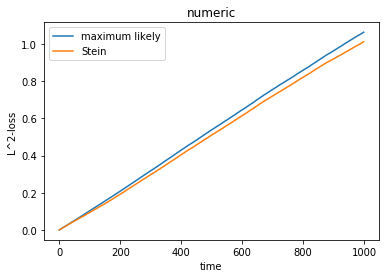

In [8]:
plt.plot(loss_X,label="maximum likely")#最尤推定量の平均二乗誤差の表示
plt.plot(loss_XDF,label="Stein") #シュタイン推定量の平均二乗誤差の表示
plt.legend()
plt.title("numeric")
plt.xlabel("time")
plt.ylabel("L^2-loss")
plt.show()

平均二乗誤差の（微妙な）改善がみられる